<a href="https://colab.research.google.com/github/nhjeong/BiS800/blob/master/Bis800_Pancreas_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPool2D, UpSampling2D, Concatenate
from keras.optimizers import Adam
from keras import backend as K
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage import exposure
from skimage.transform import resize

Using TensorFlow backend.


In [0]:
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [0]:
imgpath = './Training_and_public_Test_data/train_images'
imgarr = os.listdir(imgpath)

labelpath = './Training_and_public_Test_data/train_labels'
labelarr = os.listdir(labelpath)

imgarr.sort()
labelarr.sort()

In [0]:
# Checking slices per subject

num = []
count = 0

for i in range(len(imgarr)-1):
    if int(imgarr[i][8:10]) == int(imgarr[i+1][8:10]): 
        count = count+1
    else:
        count = count+1
        num.append(count)
        count = 0
        
count = count+1
num.append(count)


In [0]:
start = 0
last = num[0]

X = []
Y = []
for i in range(len(num)-1):
    eachX = []
    eachY = []
    for j in range(start, last):
        img = Image.open(imgpath+'/'+imgarr[j])
        img = np.array(img)    

        label = Image.open(labelpath+'/'+labelarr[j])
        label = np.array(label) 
        
        eachX.append(img)
        eachY.append(label)
    start = start + num[i]
    last = last + num[i+1]
    eachX = np.array(eachX)
    eachY = np.array(eachY)  
    X.append(eachX)
    Y.append(eachY)        
    
eachX = []
eachY = []    
for j in range(start, last):
    img = Image.open(imgpath+'/'+imgarr[j])
    img = np.array(img)    

    label = Image.open(labelpath+'/'+labelarr[j])
    label = np.array(label) 

    eachX.append(img)
    eachY.append(label)
eachX = np.array(eachX)
eachY = np.array(eachY)     
X.append(eachX)
Y.append(eachY) 
        

In [0]:
for i in range(len(X)):
    [nope, Range] = np.histogram(X[i][Y[i]==255])
    X[i][X[i] < Range[0]] = Range[0]
    X[i][X[i] > Range[-1]] = Range[-1]    
    X[i] = (X[i] - Range[0]) / (Range[-1] - Range[0])

In [0]:
X_tr = X[0]
Y_tr = Y[0]
for i in range(len(X)-11):
    X_tr = np.concatenate((X_tr, X[i+1]), axis=0)
    Y_tr = np.concatenate((Y_tr, Y[i+1]), axis=0)

In [0]:
X_va = X[40]
Y_va = Y[40]
for i in range(40, 44):
    X_va = np.concatenate((X_va, X[i+1]), axis=0)
    Y_va = np.concatenate((Y_va, Y[i+1]), axis=0)

In [0]:
X_ts = X[45]
Y_ts = Y[45]
for i in range(45, 49):
    X_ts = np.concatenate((X_ts, X[i+1]), axis=0)
    Y_ts = np.concatenate((Y_ts, Y[i+1]), axis=0)

In [0]:
X_tr = np.expand_dims(X_tr, axis=-1)
X_va = np.expand_dims(X_va, axis=-1)
X_ts = np.expand_dims(X_ts, axis=-1)

In [0]:
Y_tr = Y_tr / 255
Y_va = Y_va / 255
Y_ts = Y_ts / 255

In [0]:
Y_tr = np.concatenate((np.expand_dims(1-Y_tr, axis=-1), np.expand_dims(Y_tr, axis=-1)), axis=-1)
Y_va = np.concatenate((np.expand_dims(1-Y_va, axis=-1), np.expand_dims(Y_va, axis=-1)), axis=-1)
Y_ts = np.concatenate((np.expand_dims(1-Y_ts, axis=-1), np.expand_dims(Y_ts, axis=-1)), axis=-1)

In [0]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    
    residual = Conv2D(filters, (3, 3), padding='same')(conv1)
    residual = BatchNormalization()(residual)    
    residual = Activation('relu')(residual)    

    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual


def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same')(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    
    conv1 = Conv2D(filters, (3, 3), padding='same')(concat)
    conv1 = BatchNormalization()(conv1)   
    conv1 = Activation('relu')(conv1) 
    
    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)  
    output = Activation('relu')(conv2) 
    
    return output
  
def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = 2 * K.sum(y_true * y_pred, axis=-1)
    dice = intersection / (K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) + smooth)
    return 1-dice
  

In [0]:
ch = 1
resol = X_tr.shape[1]
minibatch_size = 12
    
    
# Make a custom U-nets implementation.
filters = 16
input_layer = Input(shape = [resol, resol, ch])
layers = [input_layer]
residuals = []

# Down 1
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5
d5 = down(d4, filters, pool=False)

# Up 1
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4
up4 = up(up3, residual=residuals[-4], filters=filters/2)

filters /= 2

fc1 = Conv2D(filters=int(filters), kernel_size=(1, 1), activation="relu")(up4)
out = Conv2D(filters=ch*2, kernel_size=(1, 1), activation="softmax")(fc1)

model = Model(input_layer, out)
model.summary() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
def display(net, X, Y, slices, answer=False):
    display_index = np.arange(100, 1100, 100)
    Y_pred = net.predict(X, batch_size=1)
    Y_map = np.argmax(Y_pred, axis=3)
    Y_ans = np.argmax(Y, axis=3)
  
  #np.random.seed()
  #ind = np.random.permutation(range(X.shape[0]))
    if answer:
        plt.figure(figsize=(20, 2))
        for i in range(slices):
            plt.subplot(1, slices, i+1)
            plt.imshow(np.squeeze(Y_ans[display_index[i],]), cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.clim((0,1))
        plt.show()
    else:
        plt.figure(figsize=(20, 4))
        for i in range(slices):
            plt.subplot(2, slices, i+1)
            plt.imshow(np.squeeze(X[display_index[i],]), cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.clim((0,1))
            plt.subplot(2, slices, i+1+slices)
            plt.imshow(Y_map[display_index[i],], cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.clim((0,1))  
        plt.show()

In [0]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

Epoch #1
Train on 4338 samples, validate on 469 samples
Epoch 1/1
4338/4338 [==============================] - 319s 74ms/step - loss: 0.1266 - val_loss: 0.6915


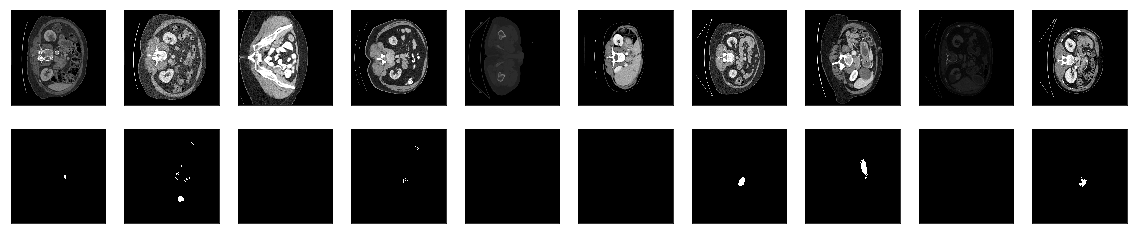

Epoch #2
Train on 4338 samples, validate on 469 samples
Epoch 1/1
4338/4338 [==============================] - 314s 72ms/step - loss: 0.0473 - val_loss: 0.8790


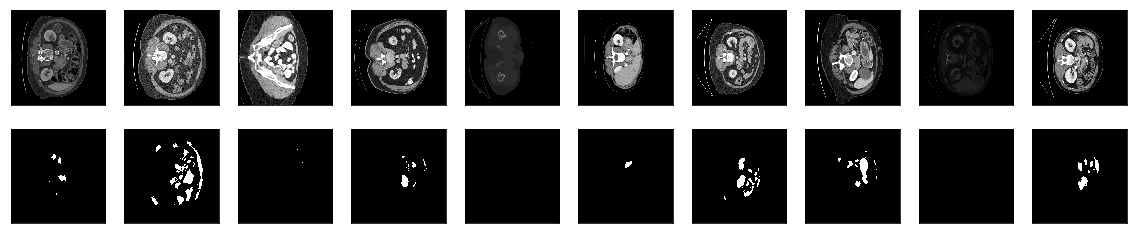

Epoch #3
Train on 4338 samples, validate on 469 samples
Epoch 1/1
4338/4338 [==============================] - 313s 72ms/step - loss: 0.0288 - val_loss: 0.9128


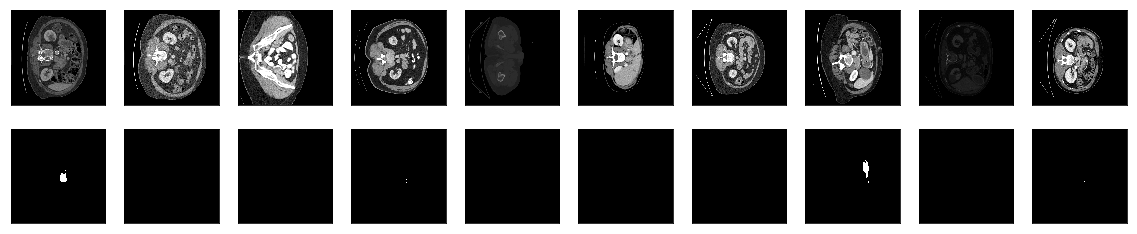

Epoch #4
Train on 4338 samples, validate on 469 samples
Epoch 1/1
4338/4338 [==============================] - 313s 72ms/step - loss: 0.0232 - val_loss: 0.8499


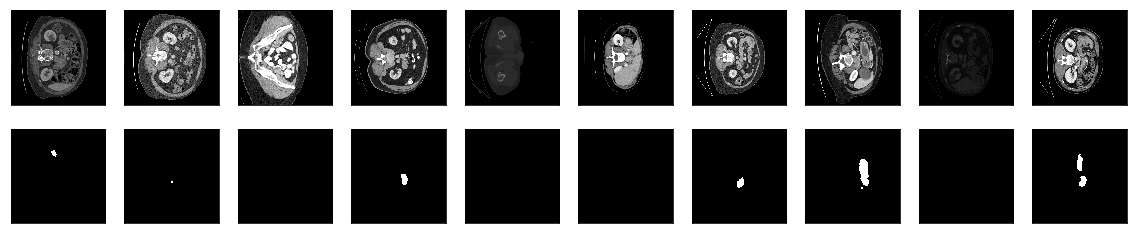

Epoch #5
Train on 4338 samples, validate on 469 samples
Epoch 1/1
4338/4338 [==============================] - 310s 71ms/step - loss: 0.0205 - val_loss: 1.1655


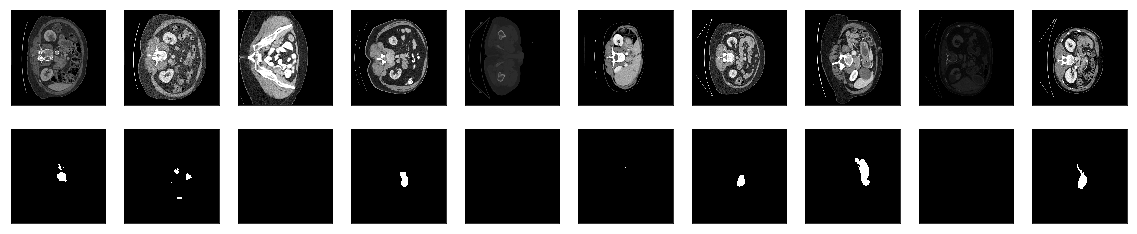

Epoch #6
Train on 4338 samples, validate on 469 samples
Epoch 1/1
4338/4338 [==============================] - 309s 71ms/step - loss: 0.0159 - val_loss: 1.1082


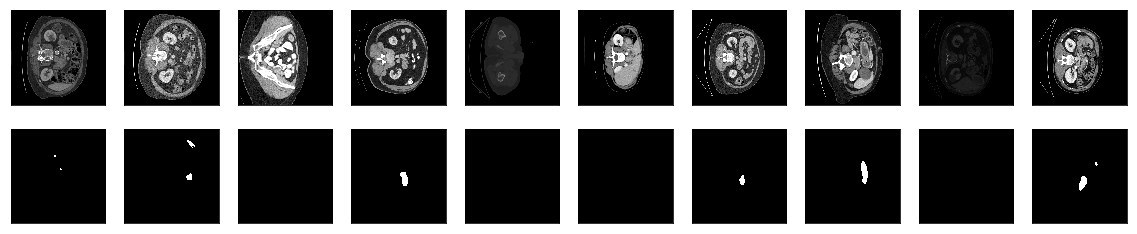

Epoch #7
Train on 4338 samples, validate on 469 samples
Epoch 1/1
4263/4338 [============================>.] - ETA: 5s - loss: 0.0149

In [0]:
model.compile(optimizer=Adam(1e-4), loss=weighted_categorical_crossentropy([1.0, 50.0]))
n_epochs = 30
train_loss = []
val_loss = []
for i in range(n_epochs):
    print('Epoch #%d' % (i+1))
    hist = model.fit(X_tr, Y_tr, validation_data=(X_va, Y_va), batch_size=1, epochs=1, verbose=1, shuffle=True)
    display(model, X_tr, Y_tr, 10)
    train_loss.append(hist.history['loss'])
    val_loss.append(hist.history['val_loss'])

display(model, X_tr, Y_tr, 10, answer=True)  
  
fig, loss_ax = plt.subplots()
loss_ax.plot(train_loss, 'b', label='training loss')
loss_ax.plot(val_loss, 'r', label='val loss')
plt.show()